<a href="https://colab.research.google.com/github/styxx216/zoomcamp_mlops/blob/main/zoomcamp_mlops_homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [331]:
!pip install --upgrade pip
!pip install --upgrade pandas

In [332]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-22 12:25:56--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.11’

housing.csv.11      100%[===================>]   1.36M  --.-KB/s    in 0.05s   

2023-09-22 12:25:56 (28.9 MB/s) - ‘housing.csv.11’ saved [1423529/1423529]



In [333]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression

In [334]:
df = pd.read_csv('housing.csv')

In [335]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


EDA

In [336]:
df['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

<Axes: ylabel='Frequency'>

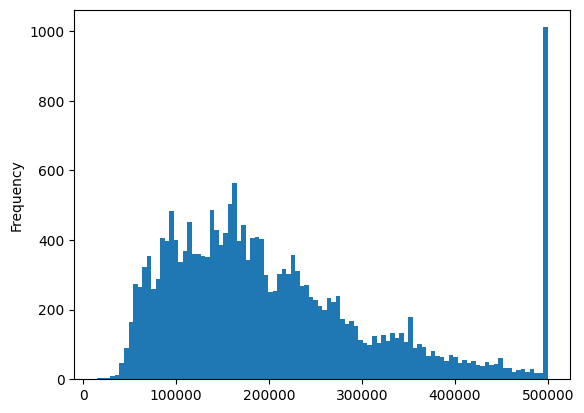

In [337]:
df['median_house_value'].plot(kind="hist",bins=100)

Preparing the dataset

In [338]:
df = df.loc[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])][['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value']]

1


In [339]:
df[['total_rooms', 'total_bedrooms', 'population', 'households']].isnull().sum()

total_rooms         0
total_bedrooms    157
population          0
households          0
dtype: int64

In [340]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

2

In [341]:
df['population'].median()

1195.0

Prepare and split the dataset


In [342]:
n = len(df)
n_train = int(n*0.6)
n_val = int(n*0.2)
n_test = n - n_train - n_val

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)


df['median_house_value'] = np.log1p(df['median_house_value'])


df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

3


In [343]:
def prepare_data(df, fill = 'mean'):
    t = df.copy()
    if fill == 'zero':
        t['total_bedrooms'] = t['total_bedrooms'].fillna(0)
    elif fill == 'mean':
        t['total_bedrooms'] = t['total_bedrooms'].fillna(t['total_bedrooms'].mean())
    X = t[t.columns[:-1]].values
    y = t[t.columns[-1]].values
    return X,y

In [344]:
def linear_regression(X,w0,w):

    n = len(X)
    res = [w0]*n
    for i in range(n):
        res[i]+=np.matmul(X[i],w)
    return res

In [345]:
def train_linear_regression(X,y,r = 0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = np.matmul(X.T, X)
    XTX+=r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    t = np.matmul(XTX_inv, X.T)
    w = np.matmul(t,y)
    return w[0], w[1:]

In [346]:
X_train,y_train = prepare_data(df_train,'zero')
w0,w = train_linear_regression(X_train,y_train)
X_val,y_val = prepare_data(df_val,'zero')
y_pred_zero = linear_regression(X_val,w0,w)

In [347]:
X_train,y_train = prepare_data(df_train,'mean')
w0,w = train_linear_regression(X_train,y_train)
X_val,y_val = prepare_data(df_val,'mean')
y_pred_mean = linear_regression(X_val,w0,w)

In [348]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [349]:
print(round(rmse(y_val,y_pred_zero),2))
print(round(rmse(y_val,y_pred_mean),2))

0.34
0.34


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<Axes: ylabel='Count'>

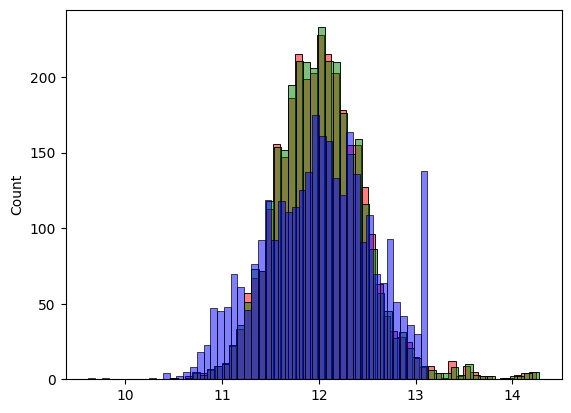

In [350]:
sns.histplot(y_pred_zero, color='red', alpha=0.5, bins=50)
sns.histplot(y_pred_mean, color='green', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)


4

In [351]:
X_train,y_train = prepare_data(df_train,'zero')
X_val,y_val = prepare_data(df_val,'zero')
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0,w = train_linear_regression(X_train,y_train, r = r)
    y_pred_zero = linear_regression(X_val,w0,w)
    print(r,round(rmse(y_val,y_pred_zero),2))

0 0.34
1e-06 0.34
0.0001 0.34
0.001 0.34
0.01 0.34
0.1 0.34
1 0.34
5 0.35
10 0.35


5

In [352]:
rmses = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]


    X_train,y_train = prepare_data(df_train,'zero')
    w0,w = train_linear_regression(X_train,y_train)
    X_val,y_val = prepare_data(df_val,'zero')
    y_pred_zero = linear_regression(X_val,w0,w)
    rmses.append(rmse(y_val,y_pred_zero))


In [353]:
rmses

[0.3377846115244761,
 0.3378066542999001,
 0.3384604473186409,
 0.33200863190600965,
 0.33944492069605114,
 0.34337807815001026,
 0.33853387112869915,
 0.34814297152927914,
 0.35127277985140115,
 0.33416623731790196]

In [354]:
np.std(rmses)

0.005631486961242433

6


In [355]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_full_train = pd.concat([df_train,df_val])

X_train,y_train = prepare_data(df_full_train,'zero')
w0,w = train_linear_regression(X_train,y_train,r = 0.001)
X_test,y_test = prepare_data(df_test,'zero')
y_pred_zero = linear_regression(X_test,w0,w)

print(round(rmse(y_pred_zero, y_test),2))

0.33
